In [1]:
!pip install torch torchvision torchaudio
!pip install diffusers transformers
!pip install tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm.notebook import tqdm

class LatentDiffusionModel(nn.Module):
    def __init__(self, latent_dim=512, image_size=256):
        super(LatentDiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512 * (image_size // 16) * (image_size // 16), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * (image_size // 16) * (image_size // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (512, image_size // 16, image_size // 16)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon


In [3]:
from torchvision.datasets import CelebA, MNIST
from torch.utils.data import DataLoader

# Transformations for CelebA-HQ
transform_celeba = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale to RGB
    transforms.Normalize((0.5,), (0.5,))
])

# Load CelebA-HQ dataset
#celeba_dataset = CelebA(root='celeba_data', split='all', transform=transform_celeba, download=True)
#celeba_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

# Load MNIST dataset
mnist_dataset = MNIST(root='mnist_data', train=True, transform=transform_mnist, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=32, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11576173.47it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346553.49it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3184163.37it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4211923.23it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LatentDiffusionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()

def train_model(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            recon_images = model(images)
            loss = criterion(recon_images, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')

# Train on CelebA-HQ dataset
#train_model(model, celeba_loader, epochs=10)

# Train on MNIST dataset
train_model(model, mnist_loader, epochs=5)


  0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.02251369827936093


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0021990846182530126


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, Loss: 0.001430651709375282


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0010937880049149194


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0008445901131257415


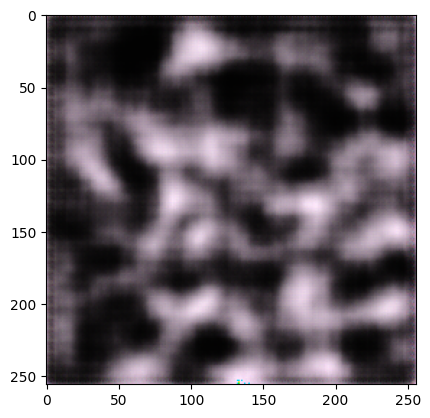

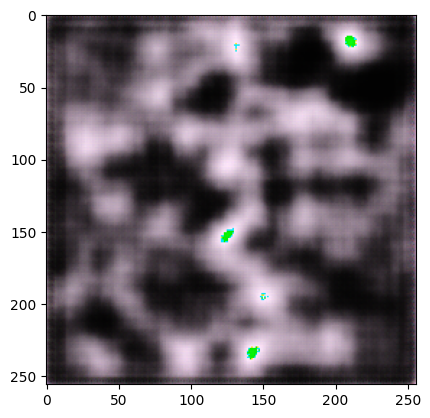

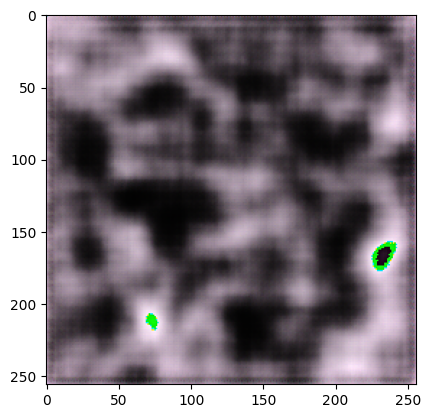

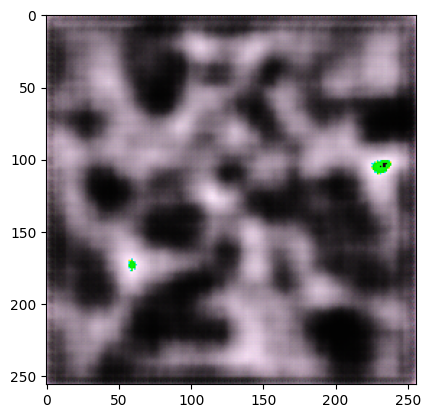

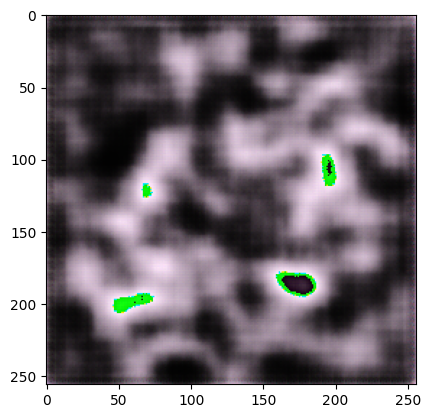

In [5]:
import matplotlib.pyplot as plt

def generate_images(model, num_images=5):
    model.eval()
    with torch.no_grad():
        for _ in range(num_images):
            latent = torch.randn(1, 512).to(device)
            generated_image = model.decode(latent).cpu().squeeze()
            plt.imshow(transforms.ToPILImage()(generated_image))
            plt.show()

# Generate images using the trained model
generate_images(model, num_images=5)